In [ ]:
!pip install onnxruntime-gpu onnx gdown cupy-cuda12x

In [ ]:
!gdown --id 1qk_3Xr6JNOigNnIO3Lwqo4AZLRobLAnB
!gdown --id 1rmzMYRbeyVp2eMhhBcidM_KHfGTcOuS-
!tar xf extracted-rois.tar
!ls

In [ ]:
from numpy.typing import NDArray
import onnxruntime as ort

from torchvision.transforms import v2
from PIL import Image
from sys import argv
import numpy as np


class FeatureExtractor:
    net: ort.InferenceSession
    rec_threshold: float
    val_transforms = v2.Compose(
        [v2.ToTensor(), v2.Normalize([0.485, 0.485, 0.406], [0.229, 0.224, 0.225])]
    )

    def __init__(
        self,
        model_path: str,
        providers: list[str] | None = None,
        rec_threshold: float = 0.3,
    ) -> None:
        if providers is None:
            providers = ort.get_available_providers()
            if "TensorrtExecutionProvider" in providers:
                providers.remove("TensorrtExecutionProvider")
        self.net = ort.InferenceSession(model_path, providers=providers)
        self.rec_threshold = rec_threshold

    def get_embbeddings(self, imgs: list[str]) -> NDArray[np.float32]:
        images = []
        for im in imgs:
            images.append(self.val_transforms(Image.open(im)).numpy())

        return self.net.run(None, {"in": images})

    def normalize(self, x, axis=-1, eps=1e-8):
        norm = np.linalg.norm(x, ord=2, axis=axis, keepdims=True)
        return x / (norm + eps)

    def is_same_person(
        self, im1: NDArray[np.float32], im2: NDArray[np.float32], threshold: float | None = None
    ) -> bool:
        if threshold is None:
            threshold = self.rec_threshold
        return np.dot(self.normalize(im1), self.normalize(im2)) >= threshold


model = FeatureExtractor("./model.onnx")

In [119]:
from collections import defaultdict
from pathlib import Path
from tqdm.auto import tqdm
TEST_DATASET = Path("extracted-rois/test")
IDENTITIES = list(TEST_DATASET.iterdir())

id_to_images = defaultdict(list)
batch_size = 256

imgs = []
for idd in IDENTITIES:
    for img in idd.iterdir():
        imgs.append((idd.name, img))

batches = []
i = 0
cur_batch = []
while i < len(imgs):
    cur_batch.append(imgs[i])

    if len(cur_batch) == batch_size or i + 1 == len(imgs):
        batches.append(cur_batch)
        cur_batch = []

    i+=1

for batch in tqdm(batches):
    preds = model.get_embbeddings([x[1] for x in batch])[0]

    for (idd, name), pred in zip(batch, preds):
        id_to_images[idd].append((f"{idd}/{name}", pred))

  0%|          | 0/21 [00:00<?, ?it/s]

In [138]:
import numpy as np
import json
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import lru_cache

@lru_cache
def factorial(n):
    i = 1
    while n != 0:
        i *= n
        n -= 1
    return i

def normalize(x, axis=-1, eps=1e-8):
    norm = np.linalg.norm(x, ord=2, axis=axis, keepdims=True)
    return x / (norm + eps)

def cuda_get_far_frr(id_to_images, threshold):
    genuine_pairs_rejected = 0
    false_pairs_accepted = 0

    genuine_pairs_total = 0
    false_pairs_total = 0

    images = list(id_to_images.values())

    far_examples = []
    frr_examples = []

    threshold -= 1e-5

    for i in tqdm(range(len(images)), leave=False):

        # Here we have few genuine pairs and maaanyy false pairs. It's something like 4-32 images for a given class vs more thran 5000 images from other classes.
        same_class_embeddings = normalize(np.array([img[1] for img in images[i]]), axis=1)

        if len(same_class_embeddings) > 1:
            same_class_filename = [img[0] for img in images[i]]
            
            same_class_cosine_similarities = np.dot(same_class_embeddings, np.transpose(same_class_embeddings))
            same_class_rejections = same_class_cosine_similarities < threshold 
            
            genuine_pairs_rejected += int(np.sum(np.triu(same_class_rejections)))
            genuine_pairs_total += factorial(len(images[i]))//(2*factorial(len(images[i]) - 2))
            
            
            idx = 0
            seen = set()
            idx_false_rejects = list(zip(*np.where(same_class_rejections)))
            while len(frr_examples) < 3 and idx < len(idx_false_rejects):
                ii, jj = idx_false_rejects[idx]
                ii = int(ii)
                jj = int(jj)
                if (jj, ii) not in seen:
                    seen.add((ii, jj))
                    frr_examples.append((same_class_filename[ii], same_class_filename[jj]))
                idx += 1

        if i != len(images) - 1:
            other_class_embeddings = normalize(np.array([img[1] for idd in images[i+1:] for img in idd]), axis=1)
            false_pairs_total += len(images[i]) * len(other_class_embeddings)
            other_class_filename = [img[0] for idd in images[i+1:] for img in idd]
    
            other_class_embeddings = np.transpose(other_class_embeddings)
    
            different_class_cosine_similarities = same_class_embeddings @ other_class_embeddings
    
            different_class_accepts = different_class_cosine_similarities >= threshold
    
            false_pairs_accepted += int(np.sum(different_class_accepts))
    
            idx_false_accepts = list(zip(*np.where(different_class_accepts)))
    
            idx = 0
            seen = set()
            while len(far_examples) < 3 and idx < len(idx_false_accepts):
                ii, jj = idx_false_accepts[idx]
                ii = int(ii)
                jj = int(jj)
                if (jj, ii) not in seen:
                    seen.add((ii, jj))
                    far_examples.append((same_class_filename[ii], other_class_filename[jj]))
                idx += 1
    return genuine_pairs_rejected / genuine_pairs_total, false_pairs_accepted / false_pairs_total, far_examples, frr_examples


results = []
thresholds = []

for i in tqdm(np.arange(-0.15, 1.001, 0.01)):
    results.append(cuda_get_far_frr(id_to_images, float(i)))
    thresholds.append(i)
    print(f"{i:.2f} -> FRR: {results[-1][0]:.4f}, FAR: {results[-1][1]:.4f}")

with open("result.json", "w") as f:
    f.write(json.dumps(results))


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

-0.15 -> FRR: 0.0000, FAR: 0.9986


  0%|          | 0/284 [00:00<?, ?it/s]

-0.14 -> FRR: 0.0000, FAR: 0.9975


  0%|          | 0/284 [00:00<?, ?it/s]

-0.13 -> FRR: 0.0000, FAR: 0.9960


  0%|          | 0/284 [00:00<?, ?it/s]

-0.12 -> FRR: 0.0000, FAR: 0.9935


  0%|          | 0/284 [00:00<?, ?it/s]

-0.11 -> FRR: 0.0000, FAR: 0.9899


  0%|          | 0/284 [00:00<?, ?it/s]

-0.10 -> FRR: 0.0000, FAR: 0.9847


  0%|          | 0/284 [00:00<?, ?it/s]

-0.09 -> FRR: 0.0000, FAR: 0.9773


  0%|          | 0/284 [00:00<?, ?it/s]

-0.08 -> FRR: 0.0000, FAR: 0.9673


  0%|          | 0/284 [00:00<?, ?it/s]

-0.07 -> FRR: 0.0000, FAR: 0.9539


  0%|          | 0/284 [00:00<?, ?it/s]

-0.06 -> FRR: 0.0000, FAR: 0.9366


  0%|          | 0/284 [00:00<?, ?it/s]

-0.05 -> FRR: 0.0000, FAR: 0.9146


  0%|          | 0/284 [00:00<?, ?it/s]

-0.04 -> FRR: 0.0001, FAR: 0.8876


  0%|          | 0/284 [00:00<?, ?it/s]

-0.03 -> FRR: 0.0001, FAR: 0.8551


  0%|          | 0/284 [00:00<?, ?it/s]

-0.02 -> FRR: 0.0002, FAR: 0.8170


  0%|          | 0/284 [00:00<?, ?it/s]

-0.01 -> FRR: 0.0004, FAR: 0.7734


  0%|          | 0/284 [00:00<?, ?it/s]

0.00 -> FRR: 0.0007, FAR: 0.7249


  0%|          | 0/284 [00:00<?, ?it/s]

0.01 -> FRR: 0.0009, FAR: 0.6721


  0%|          | 0/284 [00:00<?, ?it/s]

0.02 -> FRR: 0.0011, FAR: 0.6161


  0%|          | 0/284 [00:00<?, ?it/s]

0.03 -> FRR: 0.0014, FAR: 0.5582


  0%|          | 0/284 [00:00<?, ?it/s]

0.04 -> FRR: 0.0017, FAR: 0.4993


  0%|          | 0/284 [00:00<?, ?it/s]

0.05 -> FRR: 0.0018, FAR: 0.4410


  0%|          | 0/284 [00:00<?, ?it/s]

0.06 -> FRR: 0.0019, FAR: 0.3845


  0%|          | 0/284 [00:00<?, ?it/s]

0.07 -> FRR: 0.0020, FAR: 0.3310


  0%|          | 0/284 [00:00<?, ?it/s]

0.08 -> FRR: 0.0021, FAR: 0.2813


  0%|          | 0/284 [00:00<?, ?it/s]

0.09 -> FRR: 0.0023, FAR: 0.2362


  0%|          | 0/284 [00:00<?, ?it/s]

0.10 -> FRR: 0.0025, FAR: 0.1961


  0%|          | 0/284 [00:00<?, ?it/s]

0.11 -> FRR: 0.0026, FAR: 0.1611


  0%|          | 0/284 [00:00<?, ?it/s]

0.12 -> FRR: 0.0028, FAR: 0.1312


  0%|          | 0/284 [00:00<?, ?it/s]

0.13 -> FRR: 0.0030, FAR: 0.1060


  0%|          | 0/284 [00:00<?, ?it/s]

0.14 -> FRR: 0.0032, FAR: 0.0850


  0%|          | 0/284 [00:00<?, ?it/s]

0.15 -> FRR: 0.0035, FAR: 0.0679


  0%|          | 0/284 [00:00<?, ?it/s]

0.16 -> FRR: 0.0038, FAR: 0.0539


  0%|          | 0/284 [00:00<?, ?it/s]

0.17 -> FRR: 0.0044, FAR: 0.0427


  0%|          | 0/284 [00:00<?, ?it/s]

0.18 -> FRR: 0.0048, FAR: 0.0338


  0%|          | 0/284 [00:00<?, ?it/s]

0.19 -> FRR: 0.0054, FAR: 0.0267


  0%|          | 0/284 [00:00<?, ?it/s]

0.20 -> FRR: 0.0059, FAR: 0.0211


  0%|          | 0/284 [00:00<?, ?it/s]

0.21 -> FRR: 0.0068, FAR: 0.0167


  0%|          | 0/284 [00:00<?, ?it/s]

0.22 -> FRR: 0.0079, FAR: 0.0133


  0%|          | 0/284 [00:00<?, ?it/s]

0.23 -> FRR: 0.0092, FAR: 0.0105


  0%|          | 0/284 [00:00<?, ?it/s]

0.24 -> FRR: 0.0103, FAR: 0.0084


  0%|          | 0/284 [00:00<?, ?it/s]

0.25 -> FRR: 0.0119, FAR: 0.0066


  0%|          | 0/284 [00:00<?, ?it/s]

0.26 -> FRR: 0.0136, FAR: 0.0053


  0%|          | 0/284 [00:00<?, ?it/s]

0.27 -> FRR: 0.0153, FAR: 0.0042


  0%|          | 0/284 [00:00<?, ?it/s]

0.28 -> FRR: 0.0174, FAR: 0.0033


  0%|          | 0/284 [00:00<?, ?it/s]

0.29 -> FRR: 0.0200, FAR: 0.0026


  0%|          | 0/284 [00:00<?, ?it/s]

0.30 -> FRR: 0.0226, FAR: 0.0020


  0%|          | 0/284 [00:00<?, ?it/s]

0.31 -> FRR: 0.0256, FAR: 0.0015


  0%|          | 0/284 [00:00<?, ?it/s]

0.32 -> FRR: 0.0288, FAR: 0.0012


  0%|          | 0/284 [00:00<?, ?it/s]

0.33 -> FRR: 0.0321, FAR: 0.0009


  0%|          | 0/284 [00:00<?, ?it/s]

0.34 -> FRR: 0.0360, FAR: 0.0007


  0%|          | 0/284 [00:00<?, ?it/s]

0.35 -> FRR: 0.0402, FAR: 0.0005


  0%|          | 0/284 [00:00<?, ?it/s]

0.36 -> FRR: 0.0447, FAR: 0.0004


  0%|          | 0/284 [00:00<?, ?it/s]

0.37 -> FRR: 0.0499, FAR: 0.0003


  0%|          | 0/284 [00:00<?, ?it/s]

0.38 -> FRR: 0.0548, FAR: 0.0002


  0%|          | 0/284 [00:00<?, ?it/s]

0.39 -> FRR: 0.0602, FAR: 0.0001


  0%|          | 0/284 [00:00<?, ?it/s]

0.40 -> FRR: 0.0663, FAR: 0.0001


  0%|          | 0/284 [00:00<?, ?it/s]

0.41 -> FRR: 0.0729, FAR: 0.0001


  0%|          | 0/284 [00:00<?, ?it/s]

0.42 -> FRR: 0.0798, FAR: 0.0001


  0%|          | 0/284 [00:00<?, ?it/s]

0.43 -> FRR: 0.0871, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.44 -> FRR: 0.0951, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.45 -> FRR: 0.1031, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.46 -> FRR: 0.1115, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.47 -> FRR: 0.1207, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.48 -> FRR: 0.1303, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.49 -> FRR: 0.1405, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.50 -> FRR: 0.1512, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.51 -> FRR: 0.1621, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.52 -> FRR: 0.1732, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.53 -> FRR: 0.1843, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.54 -> FRR: 0.1966, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.55 -> FRR: 0.2089, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.56 -> FRR: 0.2223, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.57 -> FRR: 0.2362, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.58 -> FRR: 0.2498, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.59 -> FRR: 0.2647, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.60 -> FRR: 0.2803, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.61 -> FRR: 0.2970, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.62 -> FRR: 0.3141, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.63 -> FRR: 0.3315, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.64 -> FRR: 0.3502, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.65 -> FRR: 0.3689, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.66 -> FRR: 0.3888, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.67 -> FRR: 0.4099, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.68 -> FRR: 0.4327, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.69 -> FRR: 0.4534, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.70 -> FRR: 0.4768, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.71 -> FRR: 0.5011, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.72 -> FRR: 0.5257, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.73 -> FRR: 0.5494, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.74 -> FRR: 0.5734, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.75 -> FRR: 0.5983, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.76 -> FRR: 0.6233, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.77 -> FRR: 0.6483, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.78 -> FRR: 0.6723, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.79 -> FRR: 0.6960, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.80 -> FRR: 0.7195, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.81 -> FRR: 0.7427, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.82 -> FRR: 0.7647, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.83 -> FRR: 0.7862, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.84 -> FRR: 0.8072, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.85 -> FRR: 0.8279, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.86 -> FRR: 0.8466, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.87 -> FRR: 0.8646, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.88 -> FRR: 0.8827, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.89 -> FRR: 0.9000, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.90 -> FRR: 0.9170, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.91 -> FRR: 0.9329, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.92 -> FRR: 0.9478, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.93 -> FRR: 0.9613, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.94 -> FRR: 0.9739, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.95 -> FRR: 0.9843, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.96 -> FRR: 0.9922, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.97 -> FRR: 0.9973, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.98 -> FRR: 0.9992, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

0.99 -> FRR: 0.9997, FAR: 0.0000


  0%|          | 0/284 [00:00<?, ?it/s]

1.00 -> FRR: 0.9998, FAR: 0.0000


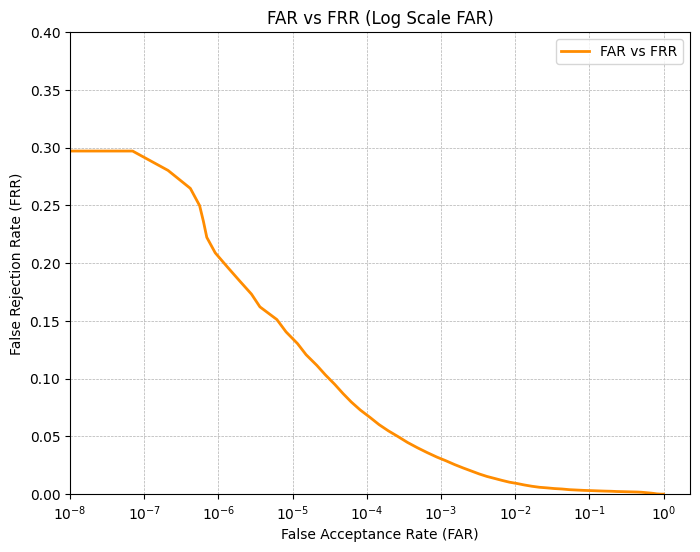

In [173]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt


far_values = np.array([r[1] for r in results])
frr_values = np.array([r[0] for r in results])

plt.figure(figsize=(8, 6))
plt.plot(
    far_values,
    frr_values, 
    color='darkorange', 
    lw=2, 
    label=f'FAR vs FRR'
)

plt.xscale("log")
plt.xticks(
    ticks=[1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    labels=["$10^0$", "$10^{-1}$", "$10^{-2}$", "$10^{-3}$", "$10^{-4}$", "$10^{-5}$", "$10^{-6}$", "$10^{-7}$", "$10^{-8}$"]
)
plt.ylim([0.0, 0.4])
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('False Rejection Rate (FRR)')
plt.title('FAR vs FRR (Log Scale FAR)')
plt.legend(loc="upper right")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

In [127]:
!df

Filesystem        1K-blocks       Used  Available Use% Mounted on
overlay          8454026148 6667682204 1786327560  79% /
tmpfs                 65536          0      65536   0% /dev
shm                14155776         44   14155732   1% /dev/shm
/dev/loop1         20466256    4187248   16262624  21% /kaggle/lib
/dev/sda1         127733284   11113244  116603656   9% /opt/bin
/dev/mapper/snap 8454026148 6667682204 1786327560  79% /etc/hosts
tmpfs              16436684          0   16436684   0% /proc/acpi
tmpfs              16436684          0   16436684   0% /proc/scsi
tmpfs              16436684          0   16436684   0% /sys/firmware
